## import libraries

In [11]:
import xarray as xr
import numpy as np
import timeit
import rioxarray
import json
from rasterio.warp import reproject, Resampling

# Vcmax data: from tif to Zarr

The Vcmax dataset is provided as geotiff.
We need to fillnan first. 
Then reproject it.
Then export to zarr. It is global.

## fillnan with rioxarray
https://stackoverflow.com/questions/58956694/interpolate-dataarray-missing-data-using-xarray
https://corteva.github.io/rioxarray/html/examples/interpolate_na.html

https://corteva.github.io/rioxarray/html/rioxarray.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

In [12]:
vcmax = xr.open_rasterio("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/Vcmax/TROPOMI_Vmax_Tg_mean.tif", engine="rasterio")

/scratch-local/qiahan.5601279/ipykernel_3696184/2198148621.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  vcmax = xr.open_rasterio("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/Vcmax/TROPOMI_Vmax_Tg_mean.tif", engine="rasterio")


In [15]:
vcmax.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray (band: 1, y: 360, x: 720)>
[259200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    spatial_ref  int64 0
Attributes:
    transform:      (0.5, 0.0, -180.0, 0.0, -0.5, 90.0)
    res:            (0.5, 0.5)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     nan

In [13]:
vcmax.rio.write_nodata(vcmax.rio.nodata, inplace=True)

<xarray.DataArray (band: 1, y: 360, x: 720)>
[259200 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.75 89.25 88.75 88.25 ... -88.25 -88.75 -89.25 -89.75
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
Attributes:
    transform:      (0.5, 0.0, -180.0, 0.0, -0.5, 90.0)
    crs:            +init=epsg:4326
    res:            (0.5, 0.5)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     nan

In [19]:
# vcmax.rio.nodata

In [17]:
vcmax_fillna = vcmax.rio.interpolate_na(method='nearest') #interpolation method see: scipy.interpolate.griddata

In [20]:
# vcmax_fillna.plot()

## load era5land data for mask igbp

In [21]:
year = 2015

In [24]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
vcmax_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc'
)
OUT_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/vcmax/vcmax_fillnan.zarr'
)

In [25]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

In [26]:
ds = xr.open_zarr(ERA5_PATH)

In [27]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)

In [28]:
vcmax_fillna = vcmax_fillna.rio.write_crs('WGS84')
vcmax_fillna = vcmax_fillna.rename(
    x='longitude',
    y='latitude',
)
vcmax_fillna = vcmax_fillna.assign_coords(
    longitude=(vcmax_fillna.longitude + 360) % 360,
    latitude=vcmax_fillna.latitude
)
# roll array to reorder coordinates 
nroll = (vcmax_fillna.longitude.values >= 180 ).sum()
vcmax_fillna = vcmax_fillna.roll(longitude=-nroll, roll_coords=True)

In [29]:
vcmax_fillna

<xarray.DataArray (band: 1, latitude: 360, longitude: 720)>
array([[[2.3253233, 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        [2.3253233, 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        [2.3253233, 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        ...,
        [0.5509907, 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907],
        [0.5509907, 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907],
        [0.5509907, 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * latitude     (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude    (longitude) float64 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     nan

In [30]:
vcmax_fillna_reprojected = vcmax_fillna.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
vcmax_fillna_reprojected = vcmax_fillna_reprojected.assign_coords({
    "x": vcmax_fillna_reprojected.x,
    "y": vcmax_fillna_reprojected.y,
})
# fix naming of coordinates
vcmax_fillna_reprojected = vcmax_fillna_reprojected.rename(
    x='longitude',
    y='latitude'
)
print(vcmax_fillna_reprojected)

<xarray.DataArray (band: 1, latitude: 1801, longitude: 3600)>
array([[[4.096395 , 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        [4.096395 , 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        [4.096395 , 2.3253233, 2.3253233, ..., 2.3253233, 2.3253233,
         2.3253233],
        ...,
        [3.816467 , 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907],
        [3.816467 , 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907],
        [3.816467 , 0.5509907, 0.5509907, ..., 0.5509907, 0.5509907,
         0.5509907]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     nan


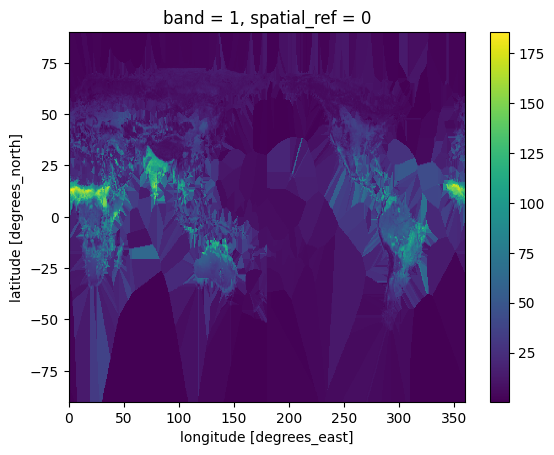

In [31]:
vcmax_fillna_reprojected.plot()

In [32]:
vcmax_fillna_reprojected = xr.where(target.notnull(), vcmax_fillna_reprojected, np.nan)

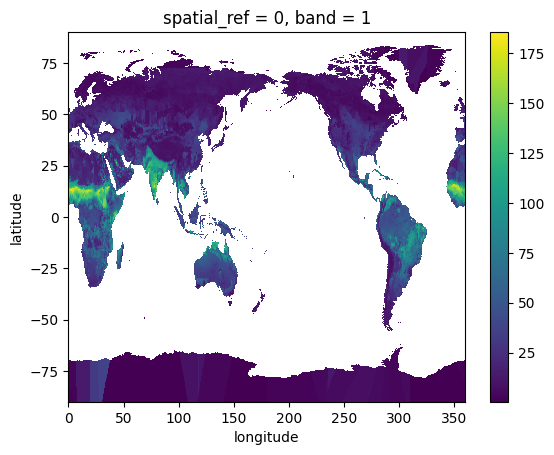

In [33]:
vcmax_fillna_reprojected.plot()

In [42]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected.where(vcmax_fillna_reprojected['latitude'] > -63, other=float('nan'))

In [43]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.to_dataset(name='vcmax')

In [44]:
vcmax_fillna_reprojected_mask

<xarray.Dataset>
Dimensions:      (latitude: 1801, longitude: 3600, band: 1)
Coordinates:
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    vcmax        (latitude, longitude, band) float32 dask.array<chunksize=(250, 250, 1), meta=np.ndarray>

In [45]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.chunk(
    longitude=250, 
    latitude=250
)
vcmax_fillna_reprojected_mask.to_zarr(OUT_PATH, mode='w')

In [94]:
xr.open_zarr(OUT_PATH).vcmax.mean().compute()

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'vcmax' ()>
array(29.640318, dtype=float32)
Coordinates:
    spatial_ref  int64 0